In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
df = pd.read_excel('/Users/rraj/Desktop/GlomData/GlomData_clean.xls', sheet_name='GIA0513')
NUMBER_OF_GLOMERULI = df.values.shape[0]
df_stats = df.describe()
df_stats

,HXH,HXH.1,HXH.2,PTO,PTO.1,PTO.2,AA,AA.1,AA.2,PNE,...,IPBE.2,CNO,CNO.1,CNO.2,BTN,BTN.1,BTN.2,IMA,IMA.1,IMA.2
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.0,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.005622,0.040292,0.050237,0.000998,0.016106,0.034936,0.000193,0.007074,0.016619,0.000332,...,0.029361,0.000638,0.0,0.000620,0.012668,0.006744,0.020759,0.000386,0.004779,0.045870
std,0.009579,0.027208,0.027041,0.004117,0.015411,0.027912,0.001591,0.016981,0.018304,0.002735,...,0.016613,0.002573,0.0,0.005116,0.007382,0.010929,0.016098,0.002236,0.016874,0.024078
min,0.000000,0.013319,0.017193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011147,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020454
25%,0.000000,0.019293,0.030351,0.000000,0.000000,0.016389,0.000000,0.000000,0.000000,0.000000,...,0.018318,0.000000,0.0,0.000000,0.010918,0.000000,0.007943,0.000000,0.000000,0.033256
50%,0.000000,0.026599,0.039032,0.000000,0.014692,0.029104,0.000000,0.000000,0.014138,0.000000,...,0.024387,0.000000,0.0,0.000000,0.012761,0.000000,0.019168,0.000000,0.000000,0.042996
75%,0.012776,0.058359,0.068642,0.000000,0.028022,0.055976,0.000000,0.011101,0.026207,0.000000,...,0.036757,0.000000,0.0,0.000000,0.016131,0.014000,0.032429,0.000000,0.000000,0.049510
max,0.038393,0.108584,0.110932,0.023128,0.055121,0.100956,0.013120,0.112290,0.111314,0.022551,...,0.087790,0.011515,0.0,0.042185,0.035245,0.043259,0.057726,0.013400,0.120891,0.207048


In [3]:
from typing import List

def label_to_idx(labels: List[str]):
    prev_label = ' '
    prev_idx = -1
    idx = []
    for label in labels:
        if prev_label[:3] not in label:
            prev_label = label
            prev_idx += 1
        idx.append(prev_idx)
    return idx

idxs = label_to_idx(list(df.columns))
LABELS_TO_IDX_DICT = {label: idx for idx, label in zip(idxs, list(df.columns))}

In [5]:
df = df.T
df = df[df_stats.T['mean'] > 0.002]
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
print(f"train_size={train_df.size//NUMBER_OF_GLOMERULI}, test_size={test_df.size//NUMBER_OF_GLOMERULI}")

train_size=83, test_size=10


In [6]:
import torch
from torch.utils.data import Dataset
from typing import Dict


class OlfactoryData(Dataset):
    def __init__(self, data: pd.DataFrame, labels_to_idx_dict: Dict):
        self.data = data.values
        self.labels = [labels_to_idx_dict[label] for label in list(data.index)]
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        sample = torch.tensor(self.data[index,:]).float()
        return sample, torch.tensor(self.labels[index]) 


train_data = OlfactoryData(train_df, LABELS_TO_IDX_DICT)
test_data = OlfactoryData(test_df, LABELS_TO_IDX_DICT)

In [7]:
import transformations
from transformations import Scale, ToVector
from layers import DiscriminationModule, AdaptationModule
from initialization import RandomInitializer, IdentityInitializer
from loading import TripletLoader
from plotting import LossPlotter, SimilarityPlotter

transforms = transformations.Compose([Scale(), ToVector()])
train_loader = TripletLoader(train_data, transforms=transforms)

out_dim = 100
lr = 0.01

layer1 = DiscriminationModule(out_dim, RandomInitializer(NUMBER_OF_GLOMERULI))
layer2 = AdaptationModule(out_dim, IdentityInitializer(), lr=lr)
layer3 = AdaptationModule(out_dim, IdentityInitializer(), lr=lr)
from testing import TestModule

#plotter = LossPlotter()
plotter = SimilarityPlotter(3)
test_module = TestModule()

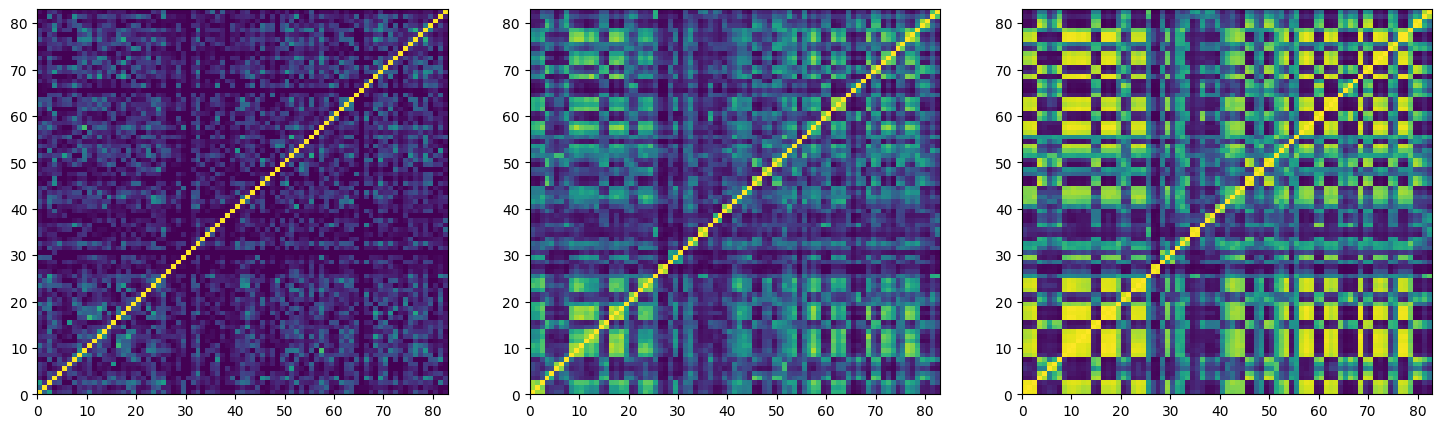

In [8]:
from tqdm import tqdm

nepochs = 50
nbatches = 50
batch_size = 89
for epoch in range(nepochs):
    batch_loss1, batch_loss2 = 0.0, 0.0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in train_loader(batch_size):
            x = layer1(x)
            x = layer2(x)
            x = layer3(x)
            
        batch_loss1 += layer2.loss/batch_size
        batch_loss2 += layer3.loss/batch_size
        
        layer1.organize()
        layer2.organize()
        layer3.organize()
    
    test_outputs, targets = test_module([layer1, layer2, layer3], test_dataset=train_data, input_transforms=transforms)
    target_indexes = torch.argsort(torch.tensor(targets))
    test_outputs = {key: value[target_indexes,:] for key, value in test_outputs.items()}
    plotter(test_outputs)    
    #plotter([batch_loss1, batch_loss2])

In [140]:
from transformations import Transform
from torch.utils.data import DataLoader
from torch.nn.functional import normalize

def test_corruption(data: Dataset, transform: Transform):
    transform1 = transformations.Compose([Scale(), ToVector()])
    transform2 = transform
    
    loader = DataLoader(data)
    
    in_clean = torch.empty(0)
    in_corrupted = torch.empty(0)
    out_clean = torch.empty(0)
    out_corrupted = torch.empty(0)
    
    labels = []
    
    for x, label in loader:
        labels.append(label)
        
        x_clean = transform1(x)
        in_clean = torch.cat((in_clean, x_clean), dim=0)
        out_clean = torch.cat((out_clean, layer1(x_clean, train=False)), dim=0) 
        
        x_corrupted = transform2(x)
        in_corrupted = torch.cat((in_corrupted, x_corrupted), dim=0)
        out_corrupted  = torch.cat((out_corrupted , layer1(x_corrupted, train=False)), dim=0)
    return labels, in_clean, in_corrupted, out_clean, out_corrupted

def test_accuracy(out_clean: torch.Tensor, out_corrupted: torch.Tensor):
    clean_norm = normalize(out_clean, p=2, dim=1)
    corrupted_norm = normalize(out_corrupted, p=2, dim=1)
    
    similiarity = torch.mm(clean_norm, corrupted_norm.T)
    correct = 0
    for idx, row in enumerate(similiarity):
        if torch.argmax(row) == idx:
            correct += 1
    return correct/similiarity.shape[0]

def specificity(x: torch.Tensor, y: torch.Tensor):
    x_norm = normalize(x, p=2, dim=1)
    y_norm = normalize(y, p=2, dim=1)
    
    similarity = torch.mm(x_norm, y_norm.T)
    specificity = (similarity - torch.mean(similarity, dim=1))/torch.std(similarity, dim=1)
    return specificity

def odor_idx(id: str, labels: List):
    odor_label = LABELS_TO_IDX_DICT.get(id)
    return (torch.tensor(labels) == odor_label).nonzero().squeeze()

def bandplot(ax, data: torch.Tensor, quantile_range: float = 0.5, color: str = 'red', label: str = None):
    q = torch.tensor([0.5*(1-quantile_range), 0.5*(1+quantile_range)])
    data_quantiles = data.quantile(q, dim=0, interpolation='higher')
    data_mean = data.mean(dim=0)
    ax.plot(data_mean, color=color)
    l = ax.fill_between(range(data.shape[1]), data_quantiles[0], data_quantiles[1], alpha=0.3, color=color, label=label)
    return l

In [24]:
from transformations import Identity
labels, in_clean, in_corr, out_clean, out_corr = test_corruption(train_data, transform=Identity())
MVE_IDX = odor_idx('MVE', labels)
INPUT_SPECIFICITY = specificity(in_clean, in_clean)
OUTPUT_SPECIFICITY = specificity(out_clean, out_clean)

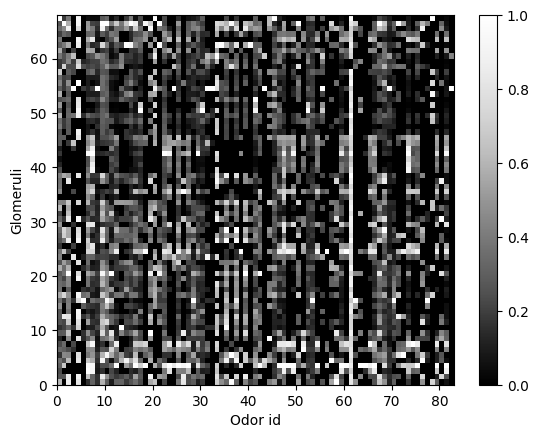

In [44]:
plt.pcolormesh(in_clean.T, cmap='Greys_r')
plt.xlabel('Odor id')
plt.ylabel('Glomeruli')
plt.colorbar()

[]

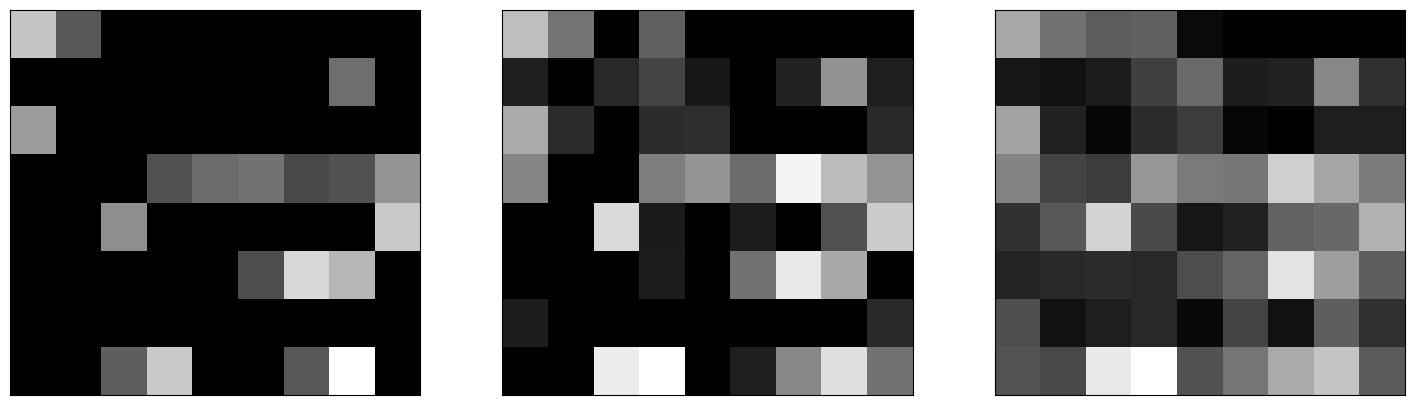

In [48]:
padded_input = torch.cat((in_clean, torch.zeros(in_clean.shape[0], 4)), dim=1)
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].pcolormesh(padded_input[MVE_IDX[2],:].reshape(8,9), cmap='Greys_r'); ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].pcolormesh(padded_input[MVE_IDX[0],:].reshape(8,9), cmap='Greys_r'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].pcolormesh(padded_input[MVE_IDX[1],:].reshape(8,9), cmap='Greys_r'); ax[2].set_xticks([]); ax[2].set_yticks([])

[]

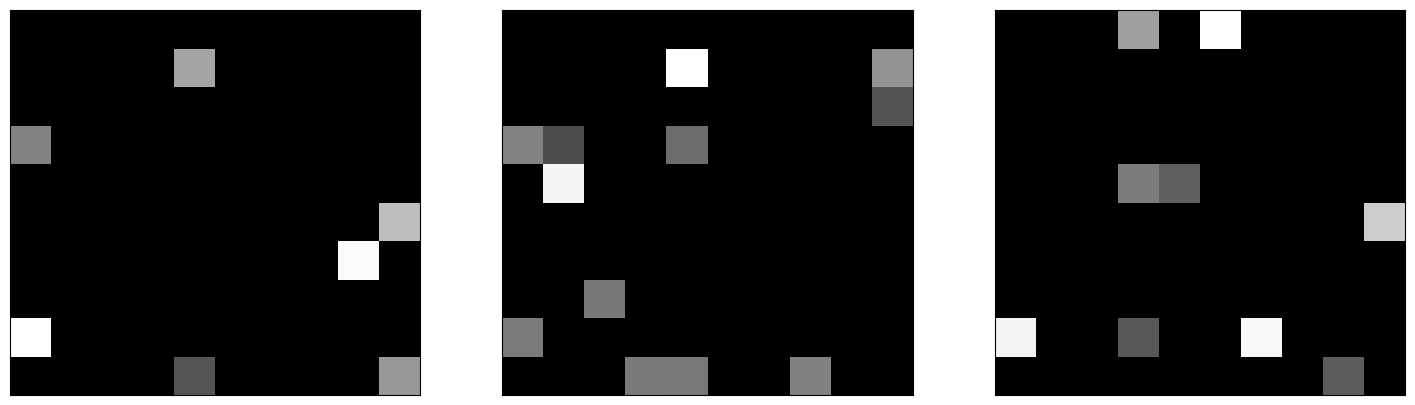

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].pcolormesh(out_clean[MVE_IDX[2],:].reshape(10,10), cmap='Greys_r'); ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].pcolormesh(out_clean[MVE_IDX[0],:].reshape(10,10), cmap='Greys_r'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].pcolormesh(out_clean[MVE_IDX[1],:].reshape(10,10), cmap='Greys_r'); ax[2].set_xticks([]); ax[2].set_yticks([])

Text(0, 0.5, 'Odor id')

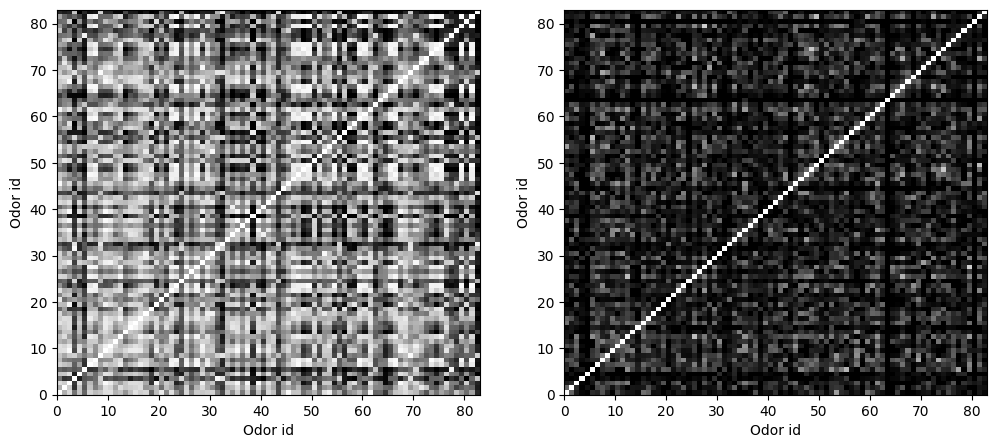

In [41]:
in_clean_norm = normalize(in_clean, p=2, dim=1)
out_clean_norm = normalize(out_clean, p=2, dim=1)
in_sim = torch.mm(in_clean_norm, in_clean_norm.T)
out_sim = torch.mm(out_clean_norm, out_clean_norm.T)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].pcolormesh(in_sim, cmap='Greys_r'); ax[0].set_xlabel('Odor id'); ax[0].set_ylabel('Odor id')
ax[1].pcolormesh(out_sim, cmap='Greys_r'); ax[1].set_xlabel('Odor id'); ax[1].set_ylabel('Odor id')

Text(0, 0.5, 'Odor id')

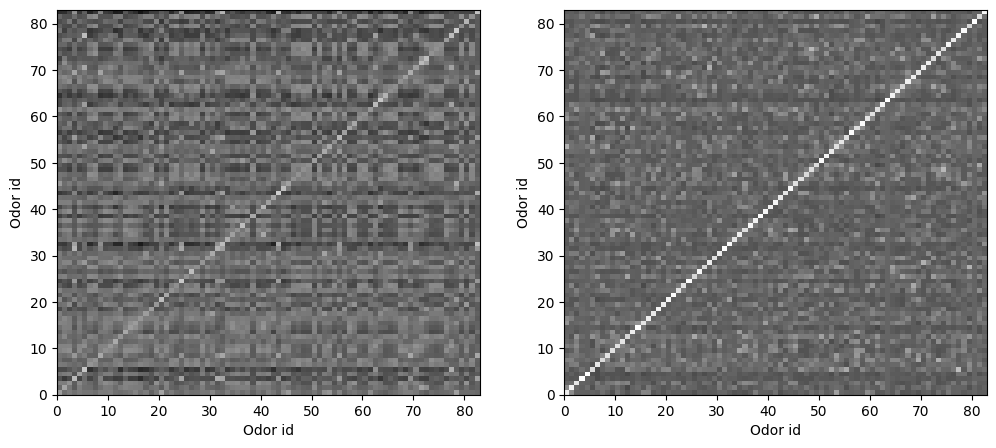

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
pcm = ax[0].pcolormesh(INPUT_SPECIFICITY, cmap='Greys_r', vmin=-4, vmax=8); ax[0].set_xlabel('Odor id'); ax[0].set_ylabel('Odor id')
pcm = ax[1].pcolormesh(OUTPUT_SPECIFICITY, cmap='Greys_r', vmin=-4, vmax=8); ax[1].set_xlabel('Odor id'); ax[1].set_ylabel('Odor id')

Text(0, 0.5, 'Specifiicity')

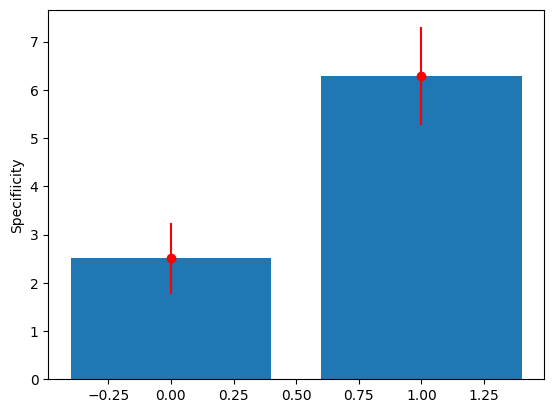

In [65]:
specificity_clean = torch.empty(0)
specificity_clean = torch.cat((specificity_clean, INPUT_SPECIFICITY.diag().unsqueeze(0)), dim=0)
specificity_clean = torch.cat((specificity_clean, OUTPUT_SPECIFICITY.diag().unsqueeze(0)), dim=0)
plt.bar([0,1], specificity_clean.mean(dim=1).tolist())
plt.errorbar([0,1], specificity_clean.mean(dim=1).tolist(), yerr=specificity_clean.std(dim=1).tolist(), fmt='o', color='red')
plt.ylabel('Specifiicity')
#specificity_clean.mean(dim=1)

([], [])

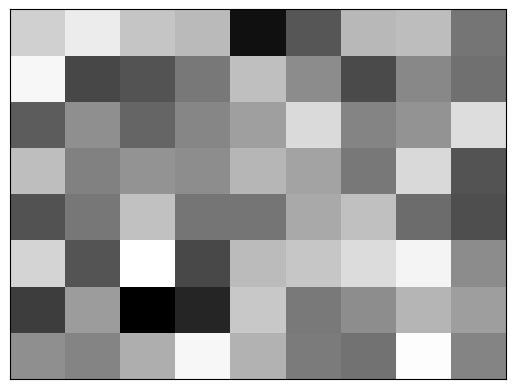

In [68]:
plt.pcolormesh(torch.randn(8,9), cmap='Greys_r')
plt.xticks([])
plt.yticks([])

In [80]:
from transformations import AddNoise

noise_level = 0.02
transform = transformations.Compose([Scale(), AddNoise(noise_level), ToVector()])
labels, in_clean, in_corr, out_clean, out_corr = test_corruption(train_data, transform=transform)

[]

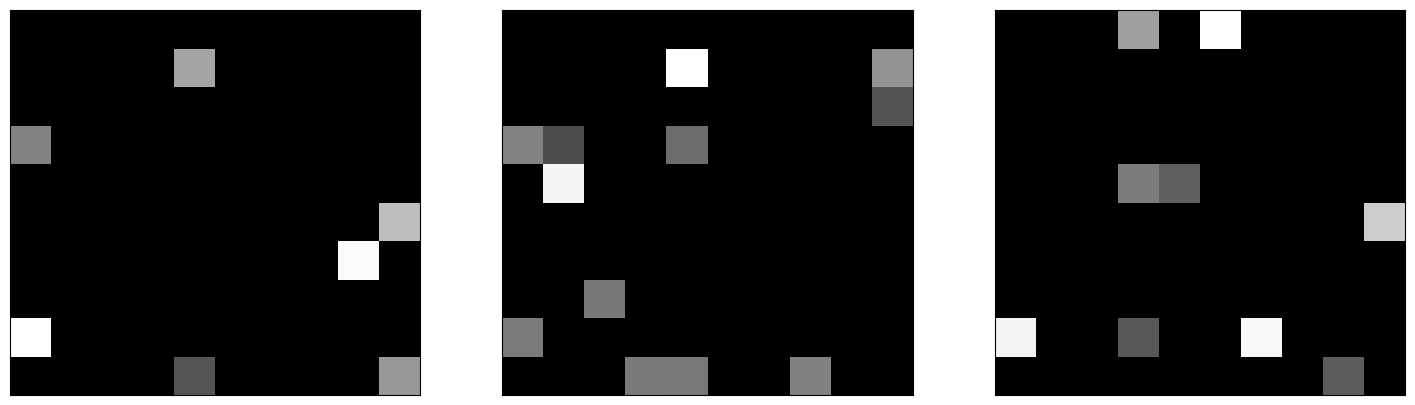

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].pcolormesh(out_clean[MVE_IDX[2],:].reshape(10,10), cmap='Greys_r'); ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].pcolormesh(out_clean[MVE_IDX[0],:].reshape(10,10), cmap='Greys_r'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].pcolormesh(out_clean[MVE_IDX[1],:].reshape(10,10), cmap='Greys_r'); ax[2].set_xticks([]); ax[2].set_yticks([])

[]

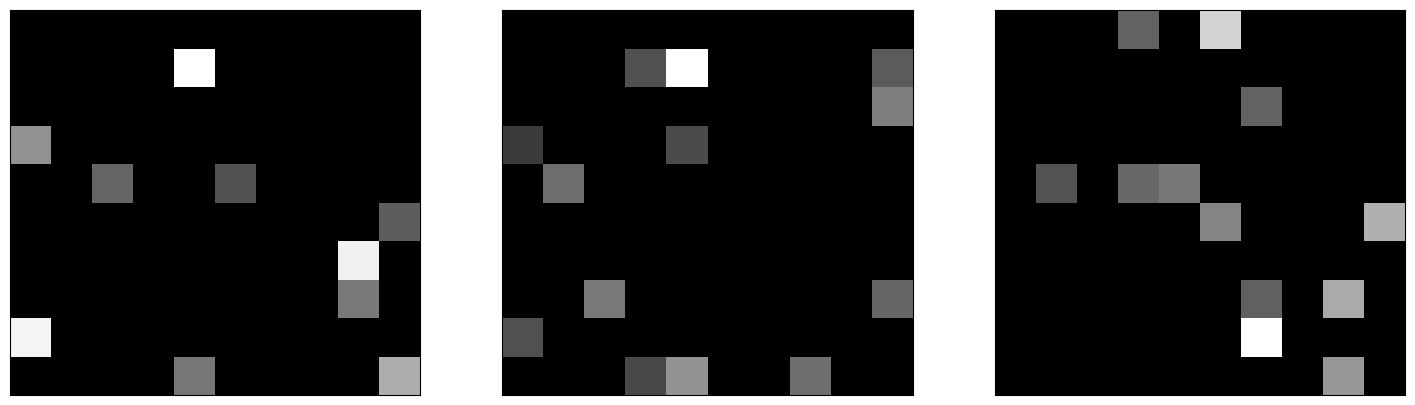

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].pcolormesh(out_corr[MVE_IDX[2],:].reshape(10,10), cmap='Greys_r'); ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].pcolormesh(out_corr[MVE_IDX[0],:].reshape(10,10), cmap='Greys_r'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].pcolormesh(out_corr[MVE_IDX[1],:].reshape(10,10), cmap='Greys_r'); ax[2].set_xticks([]); ax[2].set_yticks([])

Text(0, 0.5, 'Specificity')

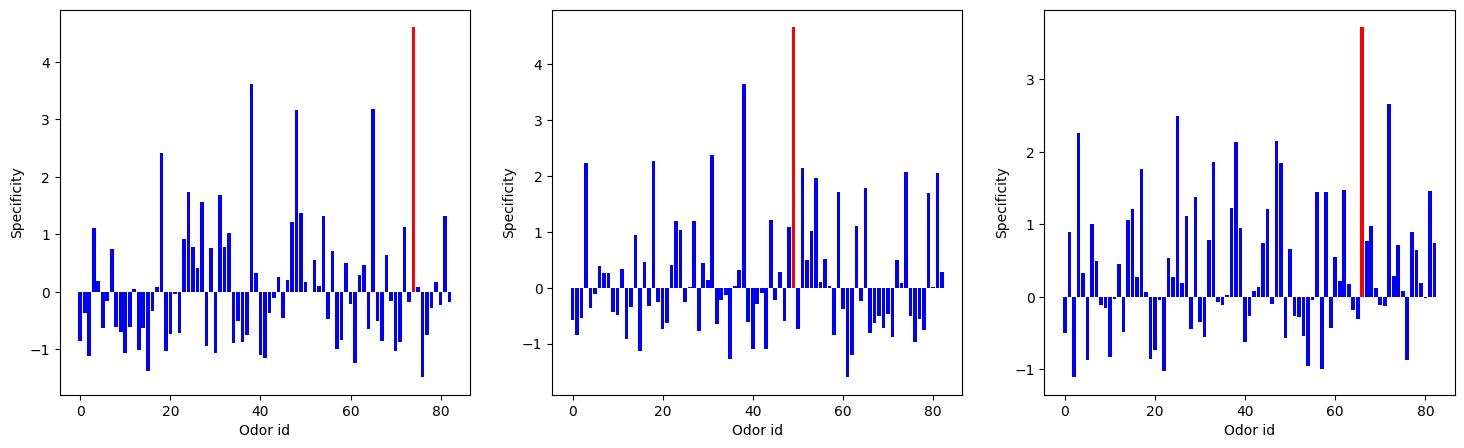

In [91]:
specificity_out_clean_corr = specificity(out_clean, out_corr)
nodors = specificity_out_clean_corr.shape[0]

fig, ax = plt.subplots(1, 3, figsize=(18,5))
colors = ['blue' if i != MVE_IDX[2] else 'red' for i in range(nodors)]
ax[0].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[2],:], color=colors); ax[0].set_xlabel('Odor id'); ax[0].set_ylabel('Specificity')
colors = ['blue' if i != MVE_IDX[0] else 'red' for i in range(nodors)]
ax[1].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[0],:], color=colors); ax[1].set_xlabel('Odor id'); ax[1].set_ylabel('Specificity')
colors = ['blue' if i != MVE_IDX[1] else 'red' for i in range(nodors)]
ax[2].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[1],:], color=colors); ax[2].set_xlabel('Odor id'); ax[2].set_ylabel('Specificity')

In [141]:
Specificty_self = []
Specificty_others = []
CorrectId = []
for trials in range(10):
    specificity_self = []
    specificity_othres = []
    correct_identification = []
    for level in range(10):
        noise_level = 0.01*level
        transform = transformations.Compose([Scale(), AddNoise(noise_level), ToVector()])
        labels, in_clean, in_corr, out_clean, out_corr = test_corruption(train_data, transform=transform)
        
        sp = specificity(out_clean, out_corr)
        specificity_self.append(sp.diag().mean().item())
        specificity_othres.append((sp.sum().item() - sp.diag().sum().item())/(sp.shape[0]*sp.shape[1]))
        
        correct_identification.append(test_accuracy(out_clean, out_corr))
    Specificty_self.append(specificity_self)
    Specificty_others.append(specificity_othres)
    CorrectId.append(correct_identification)

(0.0, 1.01)

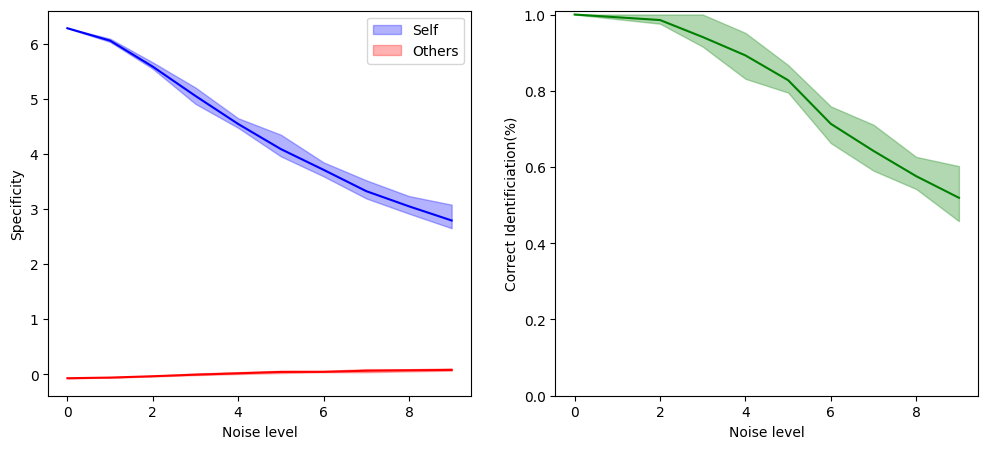

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
axis = ax[0]
l1 = bandplot(axis, torch.tensor(Specificty_self), quantile_range=0.9, color='blue', label='Self')
l2 = bandplot(axis, torch.tensor(Specificty_others), quantile_range=0.9, color='red', label='Others')
axis.set_xlabel('Noise level'); axis.set_ylabel('Specificity')
axis.legend(handles=[l1,l2])
axis = ax[1]
bandplot(axis, torch.tensor(CorrectId), quantile_range=0.9, color='green')
axis.set_xlabel('Noise level'); axis.set_ylabel('Correct Identificiation(%)')
axis.set_ylim(0,1.01)

In [108]:
from transformations import RandomSilence

noise_level = 0.02
transform = transformations.Compose([RandomSilence(noise_level), Scale(), ToVector()])
labels, in_clean, in_corr, out_clean, out_corr = test_corruption(train_data, transform=transform)

[]

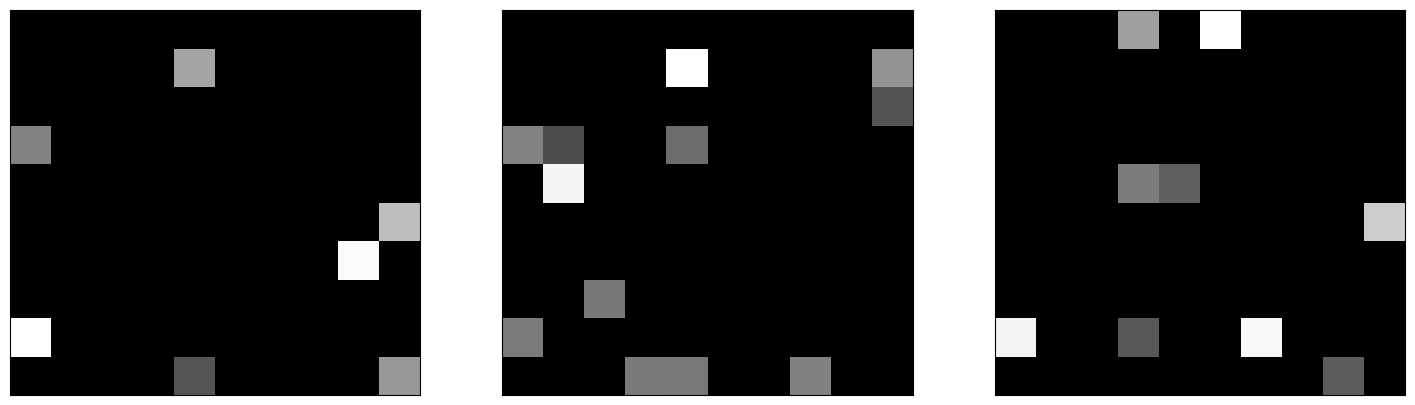

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].pcolormesh(out_corr[MVE_IDX[2],:].reshape(10,10), cmap='Greys_r'); ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].pcolormesh(out_corr[MVE_IDX[0],:].reshape(10,10), cmap='Greys_r'); ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].pcolormesh(out_corr[MVE_IDX[1],:].reshape(10,10), cmap='Greys_r'); ax[2].set_xticks([]); ax[2].set_yticks([])

Text(0, 0.5, 'Specificity')

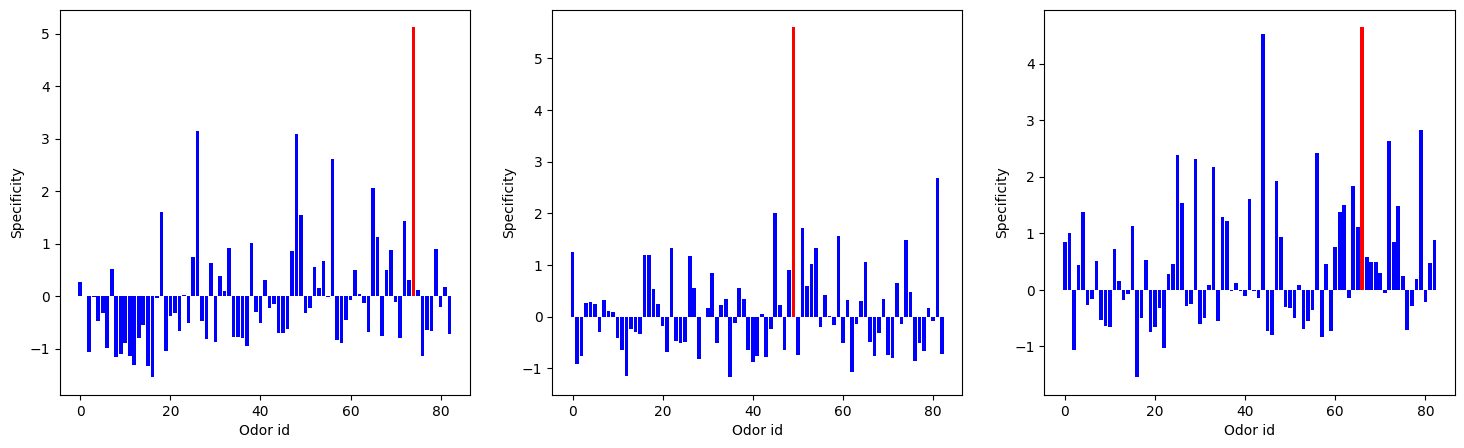

In [110]:
specificity_out_clean_corr = specificity(out_clean, out_corr)
nodors = specificity_out_clean_corr.shape[0]

fig, ax = plt.subplots(1, 3, figsize=(18,5))
colors = ['blue' if i != MVE_IDX[2] else 'red' for i in range(nodors)]
ax[0].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[2],:], color=colors); ax[0].set_xlabel('Odor id'); ax[0].set_ylabel('Specificity')
colors = ['blue' if i != MVE_IDX[0] else 'red' for i in range(nodors)]
ax[1].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[0],:], color=colors); ax[1].set_xlabel('Odor id'); ax[1].set_ylabel('Specificity')
colors = ['blue' if i != MVE_IDX[1] else 'red' for i in range(nodors)]
ax[2].bar(range(nodors), specificity_out_clean_corr[MVE_IDX[1],:], color=colors); ax[2].set_xlabel('Odor id'); ax[2].set_ylabel('Specificity')

In [144]:
Specificty_self = []
Specificty_others = []
CorrectId = []
for trials in range(10):
    specificity_self = []
    specificity_othres = []
    correct_identification = []
    for level in range(10):
        noise_level = 0.01*level
        transform = transformations.Compose([Scale(), AddNoise(noise_level), ToVector()])
        labels, in_clean, in_corr, out_clean, out_corr = test_corruption(train_data, transform=transform)
        
        sp = specificity(out_clean, out_corr)
        specificity_self.append(sp.diag().mean().item())
        specificity_othres.append((sp.sum().item() - sp.diag().sum().item())/(sp.shape[0]*sp.shape[1]))
        
        correct_identification.append(test_accuracy(out_clean, out_corr))
    Specificty_self.append(specificity_self)
    Specificty_others.append(specificity_othres)
    CorrectId.append(correct_identification)

(0.0, 1.01)

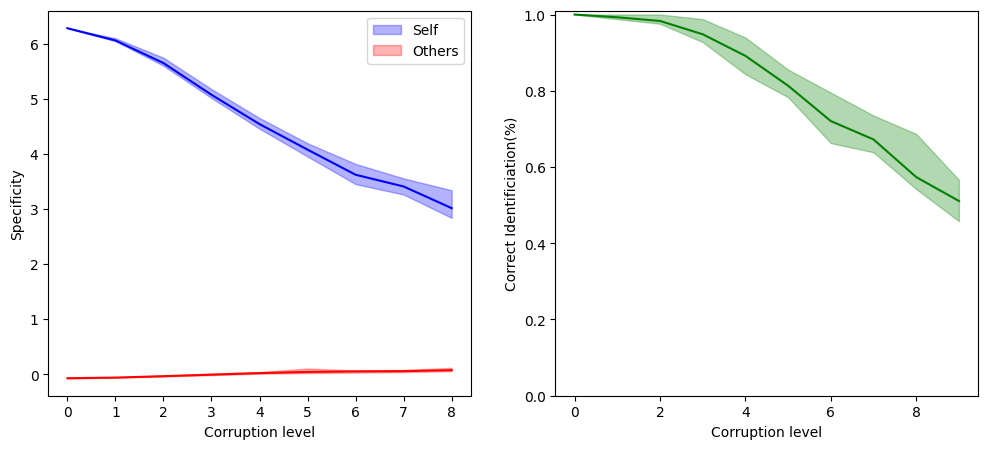

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
axis = ax[0]
l1 = bandplot(axis, torch.tensor(Specificty_self), quantile_range=0.9, color='blue', label='Self')
l2 = bandplot(axis, torch.tensor(Specificty_others), quantile_range=0.9, color='red', label='Others')
axis.set_xlabel('Corruption level'); axis.set_ylabel('Specificity')
axis.legend(handles=[l1,l2])
axis = ax[1]
bandplot(axis, torch.tensor(CorrectId), quantile_range=0.9, color='green')
axis.set_xlabel('Corruption level'); axis.set_ylabel('Correct Identificiation(%)')
axis.set_ylim(0,1.01)

([], [])

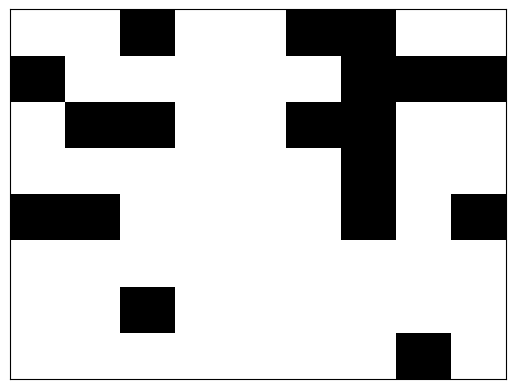

In [116]:
x = torch.ones(8,9)
y = RandomSilence(0.3)(x)
plt.pcolormesh(y, cmap='Greys_r')
plt.xticks([])
plt.yticks([])

In [155]:
x = torch.ones(1, 4)
x.norm(p='fro').item()

2.0